## No Show Intermountain Healthcare Case Study Analysis

__I outline my approach mostly in the markdown comments although some blocks of code have clarifying text__

Here I am both reading in the data and importing a variety of packages that I either used or look at using.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
import numpy as np
from sklearn.svm import SVC
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
from IPython.display import clear_output

In [68]:
no_Show = pd.read_csv("C:/Users/abedu/Downloads/No_Shows/Medical_No_Shows.csv")

## Looking at Data Features and Counts

I begin by looking at the features of the data to make sure they lined up with what I expected. Here I found Disability had 5 levels instead of 2 as expected. I work on fixing this later. I also got a general feel for how many counts there are of certain variables and their distributions.

In [69]:
print(len(no_Show))
print("\n")
print(no_Show['PatientID'].value_counts().head(n=20))
print("\n")
print(no_Show.dtypes)
print("\n")
print(no_Show['Disability'].value_counts())
print("\n")
print(no_Show['No-show'].value_counts())

110527


#822145925426128    88
#99637671331        84
#26886125921145     70
#33534783483176     65
#258424392677       62
#6264198675331      62
#75797461494159     62
#871374938638855    62
#66844879846766     57
#872278549442       55
#89239687393655     54
#8435223536         51
#853439686798559    50
#14479974122994     46
#65433599726992     46
#9452745294842      42
#81894521843749     42
#188232341789524    40
#9496196639835      38
#2271579924275      38
Name: PatientID, dtype: int64


PatientID         object
AppointmentID      int64
Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
LocationID         int64
MedicaidIND        int64
Hypertension       int64
Diabetes           int64
Alcoholism         int64
Disability         int64
SMS_received       int64
No-show           object
dtype: object


0    108286
1      2042
2       183
3        13
4         3
Name: Disability, dtype: int64


No     88208
Yes    22319
Name: No-show,

In [70]:
print(no_Show['Gender'].value_counts().head())
print("\n")
print(no_Show.groupby("Gender").mean()['SMS_received'])
print("\n")
print(no_Show['Age'].value_counts().head())

F    71840
M    38687
Name: Gender, dtype: int64


Gender
F    0.336888
M    0.291571
Name: SMS_received, dtype: float64


0     3539
1     2273
52    1746
49    1652
53    1651
Name: Age, dtype: int64


In [71]:
#Removing appointment ID as it appears to only be a indicator of the appointment.
no_Show_Clean = no_Show[['PatientID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'LocationID', 'MedicaidIND', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Disability', 'SMS_received', 'No-show']]

In [72]:
no_Show_Clean.groupby("Disability").mean()

,Age,LocationID,MedicaidIND,Hypertension,Diabetes,Alcoholism,SMS_received
Disability,,,,,,,
0,36.810465,42.386984,0.098655,0.192389,0.069667,0.030309,0.322719
1,50.855044,43.254163,0.078355,0.432419,0.174339,0.034280,0.239471
2,47.775956,49.169399,0.098361,0.459016,0.234973,0.027322,0.234973
3,48.615385,33.230769,0.000000,0.076923,0.000000,0.230769,0.230769
4,14.333333,39.333333,0.000000,0.000000,0.000000,0.000000,0.333333


## Feature Engineering

In this section I created a few new features. I created features based on the dates the appointment was scheduled and when it actually was. I looked at the hour, day of the week and the month. I also looked at the difference in time between scheduling and the actual appointment as patients may forget after a long period of time.

In [74]:
#Converting the Dates to Datetime objects to better work with them
no_Show_Clean['ScheduledDay'] = pd.to_datetime(no_Show['ScheduledDay'])
no_Show_Clean['AppointmentDay'] = pd.to_datetime(no_Show['AppointmentDay'])

C:\Users\abedu\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [75]:
#Creating a couple of variables from the scheduled day and appointment day to potentially use in a model
no_Show_Clean['ScheduledDayofWeek'] = no_Show_Clean['ScheduledDay'].dt.dayofweek
no_Show_Clean['ScheduledHourofDay'] = no_Show_Clean['ScheduledDay'].dt.hour
no_Show_Clean['ScheduledMonth'] = no_Show_Clean['ScheduledDay'].dt.month
no_Show_Clean['AppointmentDayofWeek'] = no_Show_Clean['AppointmentDay'].dt.dayofweek
no_Show_Clean['AppointmentHourofDay'] = no_Show_Clean['AppointmentDay'].dt.hour
no_Show_Clean['AppointmentMonth'] = no_Show_Clean['AppointmentDay'].dt.month
no_Show_Clean['ApptTimeAfterSchedule'] = (no_Show_Clean['AppointmentDay'] - no_Show_Clean['ScheduledDay']).astype('timedelta64[D]').astype(int)+1

I also wanted to see if some patients tended to miss often. Rather than input a bunch of patient ID's into the model which would take forever to run, I decided to calculate a few statistics on each patient such as how many appointments they have missed in the past, what proportion they have missed, and if they have shown up in the dataset before.

__I don't advise running this section of code. It takes a long time. Instead you can skip down below as you can see I saved it as a csv and then read it in again. I attached the csv with the rest of my case study submissions__.

In [492]:
#Finding how often a patient has missed an appointment in the past
appointments_made = []
appointments_missed = []
no_Show_Clean_Sorted = no_Show_Clean.sort_values(by = "AppointmentDay")
for row in range(len(no_Show_Clean_Sorted)): 
    clear_output(wait=True)
    current_patient = no_Show_Clean_Sorted['PatientID'].iloc[row]
    appointments_made.append(sum(no_Show_Clean_Sorted[:row][no_Show_Clean['PatientID']==current_patient]['No-show']=="No"))
    appointments_missed.append(sum(no_Show_Clean_Sorted[:row][no_Show_Clean['PatientID']==current_patient]['No-show']=="Yes"))
    print("Current Progress: ", np.round(row/len(no_Show_Clean_Sorted)*100,2), "%")

Current Progress:  100.0 %


In [493]:
no_Show_Clean_Sorted['AppointmentsMade'] = appointments_made
no_Show_Clean_Sorted['AppointmentsMissed'] = appointments_missed
no_Show_Clean_Sorted['ProportionMissed'] = no_Show_Clean_Sorted['AppointmentsMissed']/(no_Show_Clean_Sorted['AppointmentsMade']+no_Show_Clean_Sorted['AppointmentsMissed'])

In [494]:
no_Show_Clean_Sorted['ProportionMissed'] = no_Show_Clean_Sorted['ProportionMissed'].fillna(0)

In [441]:
#I decided not to remove disabilities, but rather to put 2-4 as "Unknown" down below. This was so that I still had the rest of the data on those rows which is accurate as far as I know.
#no_Show_Clean_Less = no_Show_Clean_Sorted[no_Show_Clean_Sorted.Disability != 2]
#no_Show_Clean_Less = no_Show_Clean_Less[no_Show_Clean_Sorted.Disability != 3]
#no_Show_Clean_Less = no_Show_Clean_Less[no_Show_Clean_Sorted.Disability != 4]

In [495]:
no_Show_Clean_Sorted = pd.get_dummies(no_Show_Clean_Sorted,prefix=['LocationID'], columns = ['LocationID'], drop_first=True)
no_Show_Clean_Sorted = pd.get_dummies(no_Show_Clean_Sorted,prefix=['Gender'], columns = ['Gender'], drop_first=True)

In [443]:
no_Show_Clean_Sorted.head()

,PatientID,ScheduledDay,AppointmentDay,Age,MedicaidIND,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,...,LocationID_73,LocationID_74,LocationID_75,LocationID_76,LocationID_77,LocationID_78,LocationID_79,LocationID_80,LocationID_81,Gender_M
0,#29872499824296,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2151,#725775968562,2016-03-29 11:09:08+00:00,2016-04-29 00:00:00+00:00,33,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2152,#94755722517728,2016-03-29 11:08:52+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2153,#35387553979251,2016-03-29 17:04:40+00:00,2016-04-29 00:00:00+00:00,69,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2154,#732498986588399,2016-04-29 17:21:24+00:00,2016-04-29 00:00:00+00:00,65,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
no_Show_Clean_Sorted.loc[no_Show_Clean_Sorted['Disability']==2,['Disability']] = "Unknown"
no_Show_Clean_Sorted.loc[no_Show_Clean_Sorted['Disability']==3,['Disability']] = "Unknown"
no_Show_Clean_Sorted.loc[no_Show_Clean_Sorted['Disability']==4,['Disability']] = "Unknown"

In [31]:
no_Show_Clean_Sorted['Disability'].value_counts()

0          108286
1            2042
Unknown       199
Name: Disability, dtype: int64

In [33]:
no_Show_Clean_Sorted = pd.get_dummies(no_Show_Clean_Sorted,prefix=['Disability'], columns = ['Disability'], drop_first=True)

In [84]:
no_Show_Clean_Sorted['Returning Patient'] = (no_Show_Clean_Sorted['AppointmentsMade']+no_Show_Clean_Sorted['AppointmentsMissed'] != 0).astype(int)

In [34]:
no_Show_Clean_Sorted.to_csv("Cleaned_Data.csv", index = False)

## EDA with new Features

Here I read the data back in so I don't have to rerun code above.

In [4]:
no_Show_Clean_Sorted = pd.read_csv("Cleaned_Data.csv")

I decided to run through more EDA in R at this point as I much prefer ggplot to the graphing features in Python when it comes to EDA. I also looked at Logistic Regression more in depth in that script as I am more comfortable doing Logistic Regression in R.

In [35]:
print(np.mean(no_Show_Clean_Sorted[no_Show_Clean_Sorted['ApptTimeAfterSchedule']>90]['Age']))
print(np.mean(no_Show_Clean_Sorted['Age']))
print(np.mean(no_Show_Clean_Sorted[no_Show_Clean_Sorted['ApptTimeAfterSchedule']<90]['Age']))
print(np.mean(no_Show_Clean_Sorted[no_Show_Clean_Sorted['ApptTimeAfterSchedule']<30]['SMS_received']))
print(np.mean(no_Show_Clean_Sorted[no_Show_Clean_Sorted['ApptTimeAfterSchedule']>30]['SMS_received']))
print(np.mean(no_Show_Clean_Sorted[no_Show_Clean_Sorted['Age']<60]['SMS_received']))
print(np.mean(no_Show_Clean_Sorted[no_Show_Clean_Sorted['Age']>60]['SMS_received']))

60.78801843317972
37.08887421173107
37.03161847404129
0.2883704560309719
0.6176527269223357
0.3228618752378181
0.31029248051816616


## Testing a few models as a baseline

Here I decide to test out 4 different machine learning models while using different features. I also look at variable importance for each of them. I then decided that Random Forest looked the best overall and so I decided to cross validate that model and tune a lot of the parameters.

In [36]:
no_Show_Clean_Sorted.columns

Index(['PatientID', 'ScheduledDay', 'AppointmentDay', 'Age', 'MedicaidIND',
       'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'No-show',
       ...
       'LocationID_75', 'LocationID_76', 'LocationID_77', 'LocationID_78',
       'LocationID_79', 'LocationID_80', 'LocationID_81', 'Gender_M',
       'Disability_1', 'Disability_Unknown'],
      dtype='object', length=103)

In [106]:
X = no_Show_Clean_Sorted.drop(['No-show', 'PatientID', 'ScheduledDay', 'AppointmentDay', 'AppointmentsMade', 'AppointmentsMissed'], axis=1)
y = no_Show_Clean_Sorted['No-show'].eq('Yes').mul(1)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 140)

In [126]:
rf= RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)
yhatforest = rf.predict(X_test)

I am mostly interested in Recall, Precision and Accuracy, but I print out a few other metrics just to make sure there isn't something very concerning.

In [127]:
print(accuracy_score(y_test, yhatforest))
print(f1_score(y_test, yhatforest))
print(precision_score(y_test, yhatforest))
print(recall_score(y_test, yhatforest))
print(roc_auc_score(y_test, yhatforest))
confusion_matrix(y_test, yhatforest)

0.8054374377996923
0.2361925057716214
0.5762564991334489
0.1485369667187849
0.5603992905520864


array([[17140,   489],
       [ 3812,   665]], dtype=int64)

In [58]:
log_reg= LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)
yhatlog = log_reg.predict(X_test)

In [59]:
print(accuracy_score(y_test, yhatlog))
print(f1_score(y_test, yhatlog))
print(precision_score(y_test, yhatlog))
print(recall_score(y_test, yhatlog))
print(roc_auc_score(y_test, yhatlog))
confusion_matrix(y_test, yhatlog)

0.7976567447751741
0.08546309548149662
0.4553376906318083
0.04715703971119133
0.5165059839271132


array([[17424,   250],
       [ 4223,   209]], dtype=int64)

In [60]:
knn= KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
yhatknn = knn.predict(X_test)

In [61]:
print(accuracy_score(y_test, yhatknn))
print(f1_score(y_test, yhatknn))
print(precision_score(y_test, yhatknn))
print(recall_score(y_test, yhatknn))
print(roc_auc_score(y_test, yhatknn))
confusion_matrix(y_test, yhatknn)

0.7658101872794716
0.2846483349454194
0.3672014260249554
0.23240072202166065
0.5659853559186044


array([[15899,  1775],
       [ 3402,  1030]], dtype=int64)

In [48]:
gradientboosting_model= GradientBoostingClassifier(n_estimators=300)
gradientboosting_model.fit(X_train, y_train)
yhatgb = gradientboosting_model.predict(X_test)

In [49]:
print(accuracy_score(y_test, yhatgb))
print(f1_score(y_test, yhatgb))
print(precision_score(y_test, yhatgb))
print(recall_score(y_test, yhatgb))
print(roc_auc_score(y_test, yhatgb))
confusion_matrix(y_test, yhatgb)

0.8043065231158961
0.1361821086261981
0.5920138888888888
0.07694043321299639
0.5318220328337246


array([[17439,   235],
       [ 4091,   341]], dtype=int64)

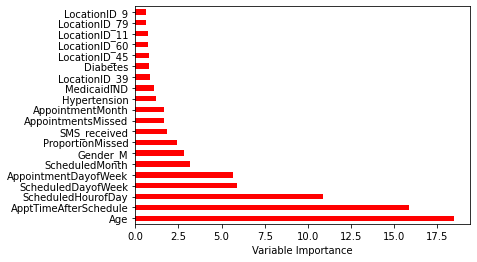

In [62]:
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X.columns)
Importance = Importance.iloc[rf.feature_importances_ > 0,:]
Importances = Importance.sort_values('Importance', axis=0, ascending=False).head(20)
Importances.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

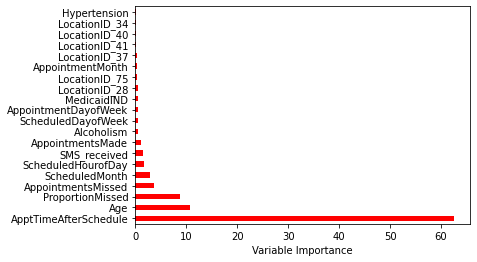

In [51]:
Importance = pd.DataFrame({'Importance':gradientboosting_model.feature_importances_*100}, index=X.columns)
Importance = Importance.iloc[gradientboosting_model.feature_importances_ > 0,:]
Importances = Importance.sort_values('Importance', axis=0, ascending=False).head(20)
Importances.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

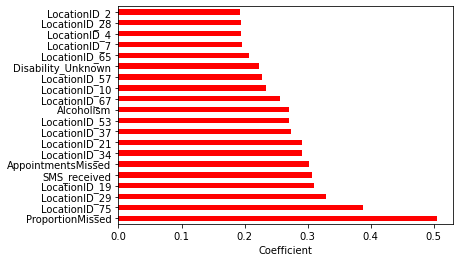

In [52]:
Coef = pd.DataFrame({'Coef':log_reg.coef_[0]}, index=X.columns)
Coef = Coef.sort_values('Coef', axis=0, ascending=False).head(20)
Coef.plot(kind='barh', color='r', )
plt.xlabel('Coefficient')
plt.gca().legend_ = None

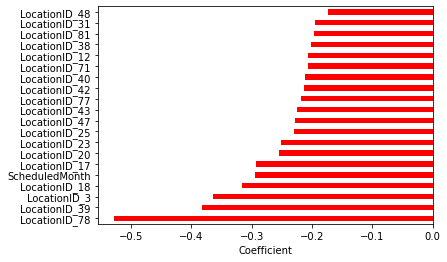

In [53]:
Coef = pd.DataFrame({'Coef':log_reg.coef_[0]}, index=X.columns)
Coef = Coef.sort_values('Coef', axis=0).head(20)
Coef.plot(kind='barh', color='r', )
plt.xlabel('Coefficient')
plt.gca().legend_ = None

In [76]:
X2 = no_Show_Clean.drop(['No-show', 'PatientID', 'ScheduledDay', 'AppointmentDay'], axis=1)
X2 = pd.get_dummies(X2,prefix=['Gender'], columns = ['Gender'], drop_first=True)
X2 = pd.get_dummies(X2,prefix=['LocationID'], columns = ['LocationID'], drop_first=True)
y2 = no_Show_Clean['No-show'].eq('Yes').mul(1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state = 140)

In [79]:
log_reg2= LogisticRegression(max_iter = 1000)
log_reg2.fit(X_train2, y_train2)
yhatlog2 = log_reg2.predict(X_test2)

In [80]:
print(accuracy_score(y_test2, yhatlog2))
print(f1_score(y_test2, yhatlog2))
print(precision_score(y_test2, yhatlog2))
print(recall_score(y_test2, yhatlog2))
print(roc_auc_score(y_test2, yhatlog2))
confusion_matrix(y_test2, yhatlog2)

0.794671130009952
0.03732767762460233
0.34509803921568627
0.019730941704035873
0.5051335202683163


array([[17479,   167],
       [ 4372,    88]], dtype=int64)

## Cross Validation

Although the end goal is to return probabilities, I also looked at what a good threshold might be if looking to classify whether or not a person will be a no-show.

In [128]:
THRESHOLD = 0.25
rfpreds = np.where(rf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

In [129]:
print(accuracy_score(y_test, rfpreds))
print(f1_score(y_test, rfpreds))
print(precision_score(y_test, rfpreds))
print(recall_score(y_test, rfpreds))
print(roc_auc_score(y_test, rfpreds))
confusion_matrix(y_test, rfpreds)

0.6969601013299557
0.45576407506702415
0.35814606741573035
0.6265356265356266
0.6706902422201078


array([[12602,  5027],
       [ 1672,  2805]], dtype=int64)

The below code also takes a long time to execute. Once ran it identified that the best parameters are to have n_estimators around 500, max depth made little difference.

In [119]:
param_grid = {'n_estimators': range(100,1500,200),
              'max_depth': range(10,100,10)}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X,y)

KeyboardInterrupt: 

In [118]:
cross_val_score(rf, X, y, cv=5, scoring='accuracy')

array([0.79480684, 0.79150457, 0.78063786, 0.78909749, 0.8       ])